这个版本使用的unet是预测的还原的图像而不是噪声？会有什么很大的差距吗？

In [ ]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

x_train是50000条32，32，3的图，test是10000条，y就是lable

In [ ]:


#######
train_dataset = torchvision.datasets.CIFAR10(
    root="cifar10/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = torchvision.datasets.CIFAR10(
    root="cifar10/",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 170M/170M [00:18<00:00, 9.00MB/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10/
Files already downloaded and verified


In [ ]:
#generate training sample by adding noise in steps, randomly pick a noise degree for an image
timesteps = 16
noise_degree = torch.tensor(1 - np.linspace(0, 1.0, timesteps + 1)).to(device)  # linspace for timesteps, inverse to timestep,step 1 pure noise

def add_noise(x, t):
    # x: [batch_size, channels, height, width]
    # t: [batch_size] tensor of timesteps

    # Convert t to tensor if it's not already
    t = torch.tensor(t).to(x.device)

    # Get noise ratios for entire batch
    noise_ratio_t = torch.tensor(noise_degree[t]).to(x.device)    # Convert to tensor
    noise_ratio_t1 = torch.tensor(noise_degree[t + 1]).to(x.device)

    # Generate noise for entire batch
    noise = torch.randn_like(x).to(x.device)

    # Reshape for broadcasting - using reshape or view with a tuple
    noise_ratio_t = noise_ratio_t.reshape((-1, 1, 1, 1))    # [batch_size, 1, 1, 1]
    noise_ratio_t1 = noise_ratio_t1.reshape((-1, 1, 1, 1))  # [batch_size, 1, 1, 1]

    # Apply noise to entire batch at once
    img_a = x * (1 - noise_ratio_t) + noise * noise_ratio_t
    img_b = x * (1 - noise_ratio_t1) + noise * noise_ratio_t1

    return img_a, img_b

In [ ]:
#cnn based autoencoder
import torch.nn as nn
class cnnmodel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        #step embedding

        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )


        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 -> 7

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7 -> 4
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 4 -> 8
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 8 -> 16
            nn.ReLU(),

            nn.ConvTranspose2d(32, in_channels, kernel_size=2, stride=2),  # 16 -> 32
            nn.Sigmoid()  # Final activation for image pixels
        )

    def forward(self, x,t):
        t = t.float().view(-1, 1)
        t = self.time_embed(t)
        x = self.encoder(x)
        t = t.view(t.shape[0], -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])
        x = x + t
        x = self.decoder(x)
        return x


In [ ]:
# build the trainner


batch_size = 128
epochs = 30

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,          # Process 64 images at once
    shuffle=True,           # Randomize order each epoch
    num_workers=2,          # Parallel data loading
    pin_memory=True        # Faster data transfer to GPU
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnnmodel(3).to(device).float()
loss_fn = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

total_loss=[]
for epoch in range(epochs):

  batch_loss = 0
  batch_count = 0
  for step,(images, _) in enumerate(train_dataloader):
    optimizer.zero_grad()
    images = images.to(device).float()
    rand_step = torch.randint(0, timesteps-1, (images.shape[0],)).to(device)  # Random timesteps for batch

    img_a, img_b = add_noise(images, rand_step)
    predict_image = model(img_a.float(),rand_step )
    loss= loss_fn(predict_image,img_b)
    loss.backward()
    optimizer.step()
    batch_loss=batch_loss+loss
    if step % 50==0:
          print(f'Epoch: {epoch}, Step: {step}, Loss: {loss.item():.4f} ')
  total_loss.append(batch_loss/batch_size)


    # optimizer.zero_grad()
    # loss=0
    # #update model until batchsize

    # image=i[0][0]
    # rand_step=np.random.randint(0, timesteps, size=1)
    # img_a,img_b= add_noise(image,rand_step)
    # predict_image = model(img_a)
    # current_loss= loss_fn(predict_image,img_b)
    # batch_loss += current_loss / batch_size
    # batch_count=batch_count+1

    # if batch_count==batch_size:

    #   batch_loss.backward()
    #   optimizer.step()
    #   optimizer.zero_grad()
    #   total_loss= total_loss+ batch_loss.item()
    #   batch_count=0
    #   batch_loss=0






<ipython-input-19-74160358c198>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).to(x.device)
<ipython-input-19-74160358c198>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_ratio_t = torch.tensor(noise_degree[t]).to(x.device)    # Convert to tensor
<ipython-input-19-74160358c198>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_ratio_t1 = torch.tensor(noise_degree[t + 1]).to(x.device)


Epoch: 0, Step: 0, Loss: 0.4866 
Epoch: 0, Step: 50, Loss: 0.4017 
Epoch: 0, Step: 100, Loss: 0.4217 
Epoch: 0, Step: 150, Loss: 0.4291 
Epoch: 0, Step: 200, Loss: 0.3922 
Epoch: 0, Step: 250, Loss: 0.4029 
Epoch: 0, Step: 300, Loss: 0.4006 
Epoch: 0, Step: 350, Loss: 0.4244 
Epoch: 1, Step: 0, Loss: 0.3873 
Epoch: 1, Step: 50, Loss: 0.4126 
Epoch: 1, Step: 100, Loss: 0.4194 
Epoch: 1, Step: 150, Loss: 0.3998 
Epoch: 1, Step: 200, Loss: 0.3790 
Epoch: 1, Step: 250, Loss: 0.3922 
Epoch: 1, Step: 300, Loss: 0.3907 
Epoch: 1, Step: 350, Loss: 0.4065 
Epoch: 2, Step: 0, Loss: 0.3995 
Epoch: 2, Step: 50, Loss: 0.3836 
Epoch: 2, Step: 100, Loss: 0.4025 
Epoch: 2, Step: 150, Loss: 0.4101 
Epoch: 2, Step: 200, Loss: 0.4260 
Epoch: 2, Step: 250, Loss: 0.4140 
Epoch: 2, Step: 300, Loss: 0.4306 
Epoch: 2, Step: 350, Loss: 0.4067 
Epoch: 3, Step: 0, Loss: 0.3983 
Epoch: 3, Step: 50, Loss: 0.4041 
Epoch: 3, Step: 100, Loss: 0.3939 
Epoch: 3, Step: 150, Loss: 0.4247 
Epoch: 3, Step: 200, Loss: 0.409

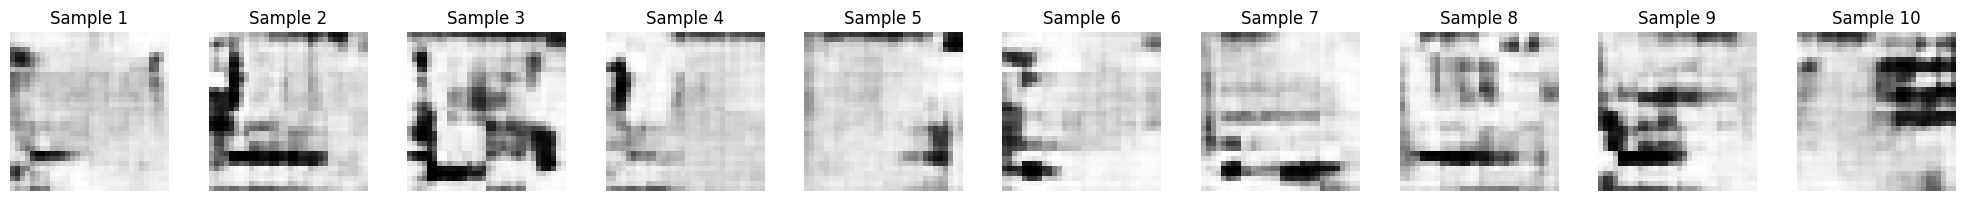

In [ ]:

image_size=(3, 32, 32)
num_samples=10
with torch.no_grad():
    # Start with pure noise
    x = torch.randn(num_samples, *image_size).to(device)

    # Gradually denoise for each timestep in 10 steps
    for t in range(timesteps):
        t_batch = torch.full((num_samples,), t, device=device)
        x = model(x, t_batch)

    x = torch.clamp(x, 0, 1)

    # Visualize results
    fig, pos = plt.subplots(1, num_samples, figsize=(20, 2))
    for i in range(num_samples):
        pos[i].imshow(x[i, 0].cpu(), cmap='gray')
        pos[i].axis('off')
        pos[i].set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()




15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [ ]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

<ipython-input-32-07e6d9795f71>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


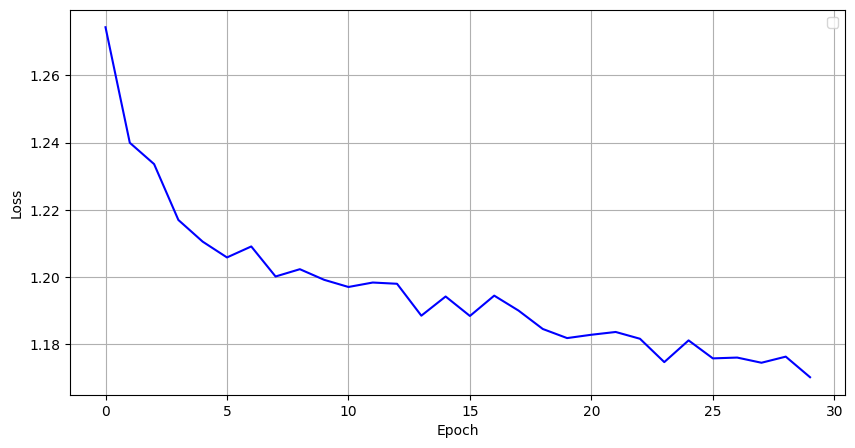

In [ ]:
total_loss_cpu = [loss.cpu().item() for loss in total_loss]

plt.figure(figsize=(10, 5))
plt.plot(range(len(total_loss_cpu)), total_loss_cpu, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

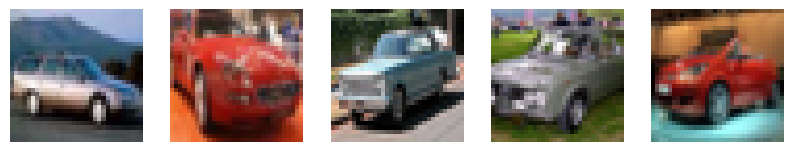

In [ ]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

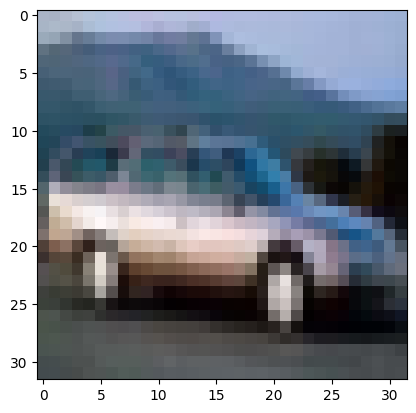

In [ ]:
plt.imshow(cvtImg(X_train[0]) )


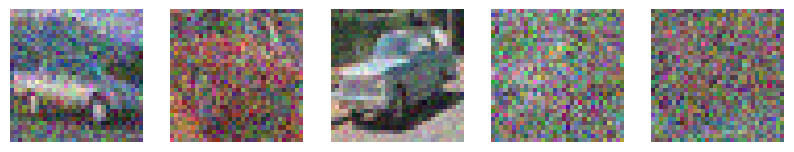

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t+1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
a, b = forward_noise(X_train[:25], t)  #一步就把noise全部加进去胃，不用分步？
show_examples(a)

每个block提取当前层次图形卷积信息，然后加上图片和当前时间步的信息

In [ ]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)  #用128个卷积核，3*3大小
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts) #表示全连接层，x的纬度会被映射成128
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

In [ ]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input') # x和x_input都创建一个tensor，只是符号，没有实际的值
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts) #为什么是192??
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)  # 2d就是2*2的pool，长和宽都会短一倍

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)  #把tensor变成1纬，应该会保留batch的纬度
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)


    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])  #这是在最后一个纬度进行concat
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x) #简单的把每个pixle变成2*2

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x) #用来合并channel的输出，conv会在每个channel计算后加总，然后就留kernel个数量的纬度
    model = tf.keras.models.Model([x_input, x_ts_input], x) #声明这个model,只需要输入输出秋可以了？, x是输出
    return model

model = make_model()
#model.summary()

(None, 512)
(None, 4, 4, 32)
(None, 4, 4, 128)
(None, 4, 4, 160)
(None, 32, 32, 128)
(None, 32, 32, 3)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

In [ ]:
x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))

In [ ]:
trange(timesteps)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
np.full((32), 6)

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

  0%|          | 0/16 [00:00<?, ?it/s]

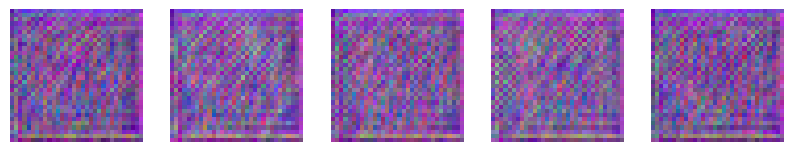

In [ ]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3)) # 初始化的随机噪声,每一次32张图
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0) #预测的目标是下一张图
    show_examples(x)

predict()

In [ ]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts) #现在这个例子，xb是比xa要噪声少一点的图
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [ ]:
def train(R=10):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
for _ in range(1):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]